# A Comparison of mannitol and glucose as sole carbon sources

### Setup imports

In [12]:
import cobra
import pandas as pd
import sys

# Disable scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

source_dir = '../src'
sys.path.append(source_dir)
from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from flux_prediction_scatterplot import flux_prediction_scatterplot
from generate_flux_map import generate_flux_map

### Load 13C-MFA data

In [2]:
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_11022023_GR.xlsx', sheet_name='1102 (not corrected)')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head(5)

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,Location on map,glucose_flux,glucose_std_err,glucose_LB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,"(-1180, 1175)",100.000000,3658.800000,100.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,"(-1376, 417)",NaN,NaN,NaN,...,100.000000,109740.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.000000,109740.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,"(-55, 111)",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.000000,0.000000,100.000000,100.000000,NaN
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,"(-1180, 960)",19.070100,698.003000,9.110600,...,-53.493200,58705.000000,-53.937700,-43.688800,10.248900,-339.511400,8.630700,-364.670900,-68.716600,295.954300


### Load model

In [3]:
model = cobra.io.json.load_json_model("../genome_scale_models/iYLI647_corr_3.json")
model

Name,model
Memory address,2a30aa560
Number of metabolites,1121
Number of reactions,1350
Number of genes,648
Number of groups,0
Objective expression,1.0*biomass_C - 1.0*biomass_C_reverse_c1d5c
Compartments,"c, e, m, n, x, r, g, v"


### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [4]:
model.reactions.get_by_id('EX_glc(e)').id = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x2a38da7d0
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Add farnesyl diphosphate (FPP) exchange reaction to create a terpenoid reaction to maximize

In [5]:
# create the exchange reaction for farnesyl diphosphate
exchange_reaction = cobra.Reaction('EX_frdp[c]')
exchange_reaction.name = 'Exchange reaction for farnesyl diphosphate'
exchange_reaction.subsystem = 'Exchange'
exchange_reaction.lower_bound = 0
exchange_reaction.upper_bound = 1000
exchange_reaction.add_metabolites({model.metabolites.get_by_id('frdp[c]'): -1})
model.add_reactions([exchange_reaction])

### Add mannitol uptake metabolites and reactions to the model

In [6]:
# Extracellular mannitol
mannitol_e = cobra.Metabolite(
    'mannitol[e]',
    formula='C6H14O6',
    name='Mannitol',
    compartment='C_e')

# Cytosolic mannitol
mannitol_c = cobra.Metabolite(
    'mannitol[c]',
    formula='C6H14O6',
    name='Mannitol',
    compartment='C_c')

mannitol_exchange = cobra.Reaction('EX_mannitol_e')
mannitol_exchange.name = 'mannitol exchange'
mannitol_exchange.lower_bound = 0.  
mannitol_exchange.upper_bound = 1000.  
mannitol_exchange.add_metabolites({
    mannitol_e: -1.0,
})

mannitol_transport = cobra.Reaction('mannitol_transport')
mannitol_transport.name = 'mannitol transport'
mannitol_transport.lower_bound = 0. 
mannitol_transport.upper_bound = 1000. 
mannitol_transport.add_metabolites({
    mannitol_e: -1.0,
    mannitol_c:  1.0,
}) 

# EC 1.14.13.244
# add this reaction: nad_c + mnl_c ⇌ fru_c + h_c + nadh_c
mannitol_dehydrogenase = cobra.Reaction('MNLDH2')
mannitol_dehydrogenase.name = 'mannitol dehydrogenase'
mannitol_dehydrogenase.lower_bound = 0.
mannitol_dehydrogenase.upper_bound = 1000.  # This is the default
mannitol_dehydrogenase.add_metabolites({
    mannitol_c: -1.0,
    model.metabolites.get_by_id('nadp[c]'):   -1.0,
    model.metabolites.get_by_id('h[c]'): 1.0,
    model.metabolites.get_by_id('fru[c]'): 1.0,
    model.metabolites.get_by_id('nadph[c]'):  1.0,
})

model.add_reactions([mannitol_exchange])
model.add_reactions([mannitol_transport])
model.add_reactions([mannitol_dehydrogenase])

### Run biomass-maximizing FBA for glucose

In [9]:
# minimal medium with glycerol as sole carbon source
model.medium = {
  'EX_glc_e': 100.0, # 100 mmol of glucose
  'EX_mannitol_e': 0,
  'EX_h2o_e': 10000.0,
  'EX_h_e': 10000.0,
  'EX_nh4_e': 10000.0,
  'EX_o2_e': 10000.0,
  'EX_pi_e': 10000.0,
  'EX_so4_e': 10000.0,
}
  
with model:
    # update the model to use the specified medium
    medium = model.medium

    # print the medium
    print('Media composition:')
    [print(model.medium[m], m) for m in model.medium]

    # set the objective to be the biomass reaction (this is the default behavior, but we'll be explicit)
    model.objective = model.reactions.get_by_id('EX_biom')

    # find the optimal solution
    solution = cobra.flux_analysis.pfba(model)

    print('\nBiomass flux', solution.fluxes['EX_biom'])

    # make a list of dictionaries with the reaction id, name, flux, and absolute flux
    reactions = []
    for reaction_id, flux in solution.fluxes.items():
      reactions.append({
        'reaction_id': reaction_id,
        'reaction_name': model.reactions.get_by_id(reaction_id).name,
        'full_reaction': model.reactions.get_by_id(reaction_id).reaction,
        'glucose_max_biomass_flux': flux,
        'absolute_flux': abs(flux), # use for sorting, then drop
      })

    # make a dataframe from the list of dictionaries
    fba_results_df = pd.DataFrame(reactions)

    # sort the dataframe by absolute flux
    fba_results_df = fba_results_df.sort_values(by=['absolute_flux'], ascending=False)

    # drop the absolute flux column
    fba_results_df = fba_results_df.drop(columns=['absolute_flux'])

fba_results_df.head()


EX_mannitol_e does not seem to be an an exchange reaction. Applying bounds anyway.


Media composition:
100.0 EX_glc_e
10000.0 EX_h2o_e
10000.0 EX_h_e
10000.0 EX_nh4_e
10000.0 EX_o2_e
10000.0 EX_pi_e
10000.0 EX_so4_e

Biomass flux 12.749804810282859


,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-585.152828
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],353.358197
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],347.604940
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,339.174176
421,EX_h2o_e,H2O exchange,h2o[e] <=>,326.765643


### Add glucose max biomass to central pathway dataframe

In [11]:
full_central_rxn_df = add_flux_column_to_13c_flux_df(central_rxn_df, fba_results_df, 'glucose_max_biomass_flux')
full_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,Location on map,glucose_flux,glucose_std_err,glucose_LB,...,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB,glucose_max_biomass_flux
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,"(-1180, 1175)",100.000000,3658.800000,100.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,"(-1376, 417)",NaN,NaN,NaN,...,109740.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,109740.000000,100.000000,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,"(-55, 111)",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.000000,0.000000,100.000000,100.000000,NaN,0.000000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,"(-1180, 960)",19.070100,698.003000,9.110600,...,58705.000000,-53.937700,-43.688800,10.248900,-339.511400,8.630700,-364.670900,-68.716600,295.954300,29.434150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,biomass formation,R80,NaN,biomass_C or biomass_glucose or biomass_oil,biomass_formation,cytosol,"(-1670, -1049)",11.258600,411.940700,9.846300,...,6544.200000,5.762300,6.153100,0.390800,33.312100,1.074500,30.166700,43.494900,13.328200,12.749805
67,energy metabolism,R81,ATP -> ATP_maintenance,ATPM,energy_metabolism,cytosol,NaN,613.462800,22445.000000,436.296700,...,377060.000000,313.171200,379.067600,65.896400,2733.800000,208.037600,987.094000,3299.400000,2312.306000,0.000000
68,energy metabolism,R82,NADH -> NADPH,NaN,NaN,NaN,NaN,33.591700,27366.000000,0.000000,...,208020.000000,0.000000,22.000100,22.000100,0.000001,0.000000,0.000000,774.681200,774.681200,
69,energy metabolism,R83,NADH -> 2*ATP,NaN,NaN,NaN,NaN,280.346900,10257.000000,210.306700,...,134300.000000,106.963200,135.114000,28.150800,1199.500000,72.033300,NaN,1408.100000,NaN,


### Plot glucose max biomass data

In [15]:
import pandas as pd
from IPython.display import display, Image
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox, TextArea)
plt.ioff()

# This function takes in a flux data frame and column name, and generates a flux map using the flux values in the specified column
def generate_flux_map(
    flux_df=None, 
    flux_column=None, 
    title_string='',
    file_name='',
    use_mannitol_map=False
):
    flux_df = flux_df.copy()

    if use_mannitol_map:
        unlabeled_image = plt.imread('../figures/templates/flux_map_mannitol.png')
    else:
        unlabeled_image = plt.imread('../figures/templates/flux_map_1_carbon_source.png')

    # add a rows for computed values if the flux column is a single column
    if isinstance(flux_column, str):
        # add a row for the second oleic acid uptake flux value
        oleic_acid_uptake_row = flux_df[flux_df['ID'] == 'OA uptake']
        oleic_acid_accoa_value = 9 * oleic_acid_uptake_row[flux_column].iloc[0]

        pp_to_f6p_row_1 = flux_df[flux_df['Equation'] == 'E4P + TKC2 <-> F6P']
        pp_to_f6p_value_1 = pp_to_f6p_row_1[flux_column].iloc[0]

        pp_to_f6p_row_2 = flux_df[flux_df['Equation'] == 'GAP + TAC3 <-> F6P']
        pp_to_f6p_value_2 = pp_to_f6p_row_2[flux_column].iloc[0]

        pp_to_gap_row_1 = flux_df[flux_df['Equation'] == 'X5P <-> GAP + TKC2']
        pp_to_gap_value_1 = pp_to_gap_row_1[flux_column].iloc[0]

        pp_to_gap_row_2 = flux_df[flux_df['Equation'] == 'GAP + TAC3 <-> F6P']
        pp_to_gap_value_2 = pp_to_gap_row_2[flux_column].iloc[0]

        biomass_row = flux_df[flux_df['pathway'] == 'biomass_formation']
        biomass_g_value = biomass_row[flux_column].iloc[0]

        co2_loss_row = flux_df[flux_df['Equation'] == 'CO2 -> CO2_EX']
        co2_loss_value = co2_loss_row[flux_column].iloc[0]

        oleic_acid_accoa = {'Location on map': '(437, 111)', flux_column: oleic_acid_accoa_value}
        ppp_to_f6p = {'Location on map': '(-643, 890)', flux_column: pp_to_f6p_value_1 + pp_to_f6p_value_2}
        ppp_to_gap = {'Location on map': '(-571, 422)', flux_column: pp_to_gap_value_1 - pp_to_gap_value_2}
        # biomass_g = {'Location on map': '(-1670, -1049)', flux_column: biomass_g_value}
        # co2_loss = {'Location on map': '(-1670, -1155)', flux_column: co2_loss_value}

        # add the new rows to the dataframe
        for new_data in [oleic_acid_accoa, ppp_to_f6p, ppp_to_gap]:
            new_row = pd.Series(new_data, index=flux_df.columns)
            new_row_df = pd.DataFrame([new_row])
            new_row_df = new_row_df.reindex(columns=flux_df.columns)
            flux_df = pd.concat([flux_df, new_row_df], ignore_index=True)

    # calculate the figure size based on the image dimensions and desired DPI
    dpi = 50  # for example, set this to your preferred DPI
    fig_width = unlabeled_image.shape[1] / dpi
    fig_height = unlabeled_image.shape[0] / dpi

    # create a figure with the calculated size
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi, facecolor='white')
    imagebox = OffsetImage(unlabeled_image)
    imagebox.image.axes = ax
    xy = (0.5, 0.5)
    ab = AnnotationBbox(imagebox, xy, frameon=False)
    ax.add_artist(ab)

    # loop over each reaction in the dataframe
    for _, row in flux_df.iterrows():        
        # check that there is a location for the reaction's flux
        if not pd.isnull(row['Location on map']):
            # get the flux value
            if isinstance(flux_column, str):
                flux_value = row[flux_column] if not pd.isnull(row[flux_column]) else 0
                flux_value = 'N/A' if flux_value == '' else f'{flux_value:.1f}'
            else:
                flux_value_1 = row[flux_column[0]] if not pd.isnull(row[flux_column[0]]) else 0
                flux_value_2 = row[flux_column[1]] if not pd.isnull(row[flux_column[1]]) else 0

                flux_value_1 = 'N/A' if flux_value_1 == '' else f'{flux_value_1:.1f}'
                flux_value_2 = 'N/A' if flux_value_2 == '' else f'{flux_value_2:.1f}'

                flux_value = f'({flux_value_1}, {flux_value_2})'

            # get the location of the reaction's flux on the map as a tuple
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            # create a text area with the flux value
            offsetbox = TextArea(
                flux_value,
                textprops=dict(fontsize=40, color='black', fontweight='bold', fontfamily='Arial')
            )
            
            # creates an annotation box, which is a box that can be placed on the plot area.
            ab = AnnotationBbox(
                offsetbox, 
                xy,
                xybox=location_tuple,
                xycoords='data',
                boxcoords="offset points",
                frameon=False
            )

            # add the annotation box to the plot area
            ax.add_artist(ab)


    # Display the plot title
    offsetbox = TextArea(
        title_string,
        textprops=dict(fontsize=80, color='black', fontweight='bold', fontfamily='Arial')
    )
    
    # creates an annotation box, which is a box that can be placed on the plot area.
    ab = AnnotationBbox(
        offsetbox, 
        xy,
        xybox=tuple((1600, 1137)),
        xycoords='data',
        boxcoords="offset points",
        frameon=False
    )

    # add the title annotation box to the plot area
    ax.add_artist(ab)

    # ensure that the axes have minimal styles 
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    # save the figure with a white background and no transparency
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0, facecolor='white', transparent=False)

    display(Image(file_name, width=1000))

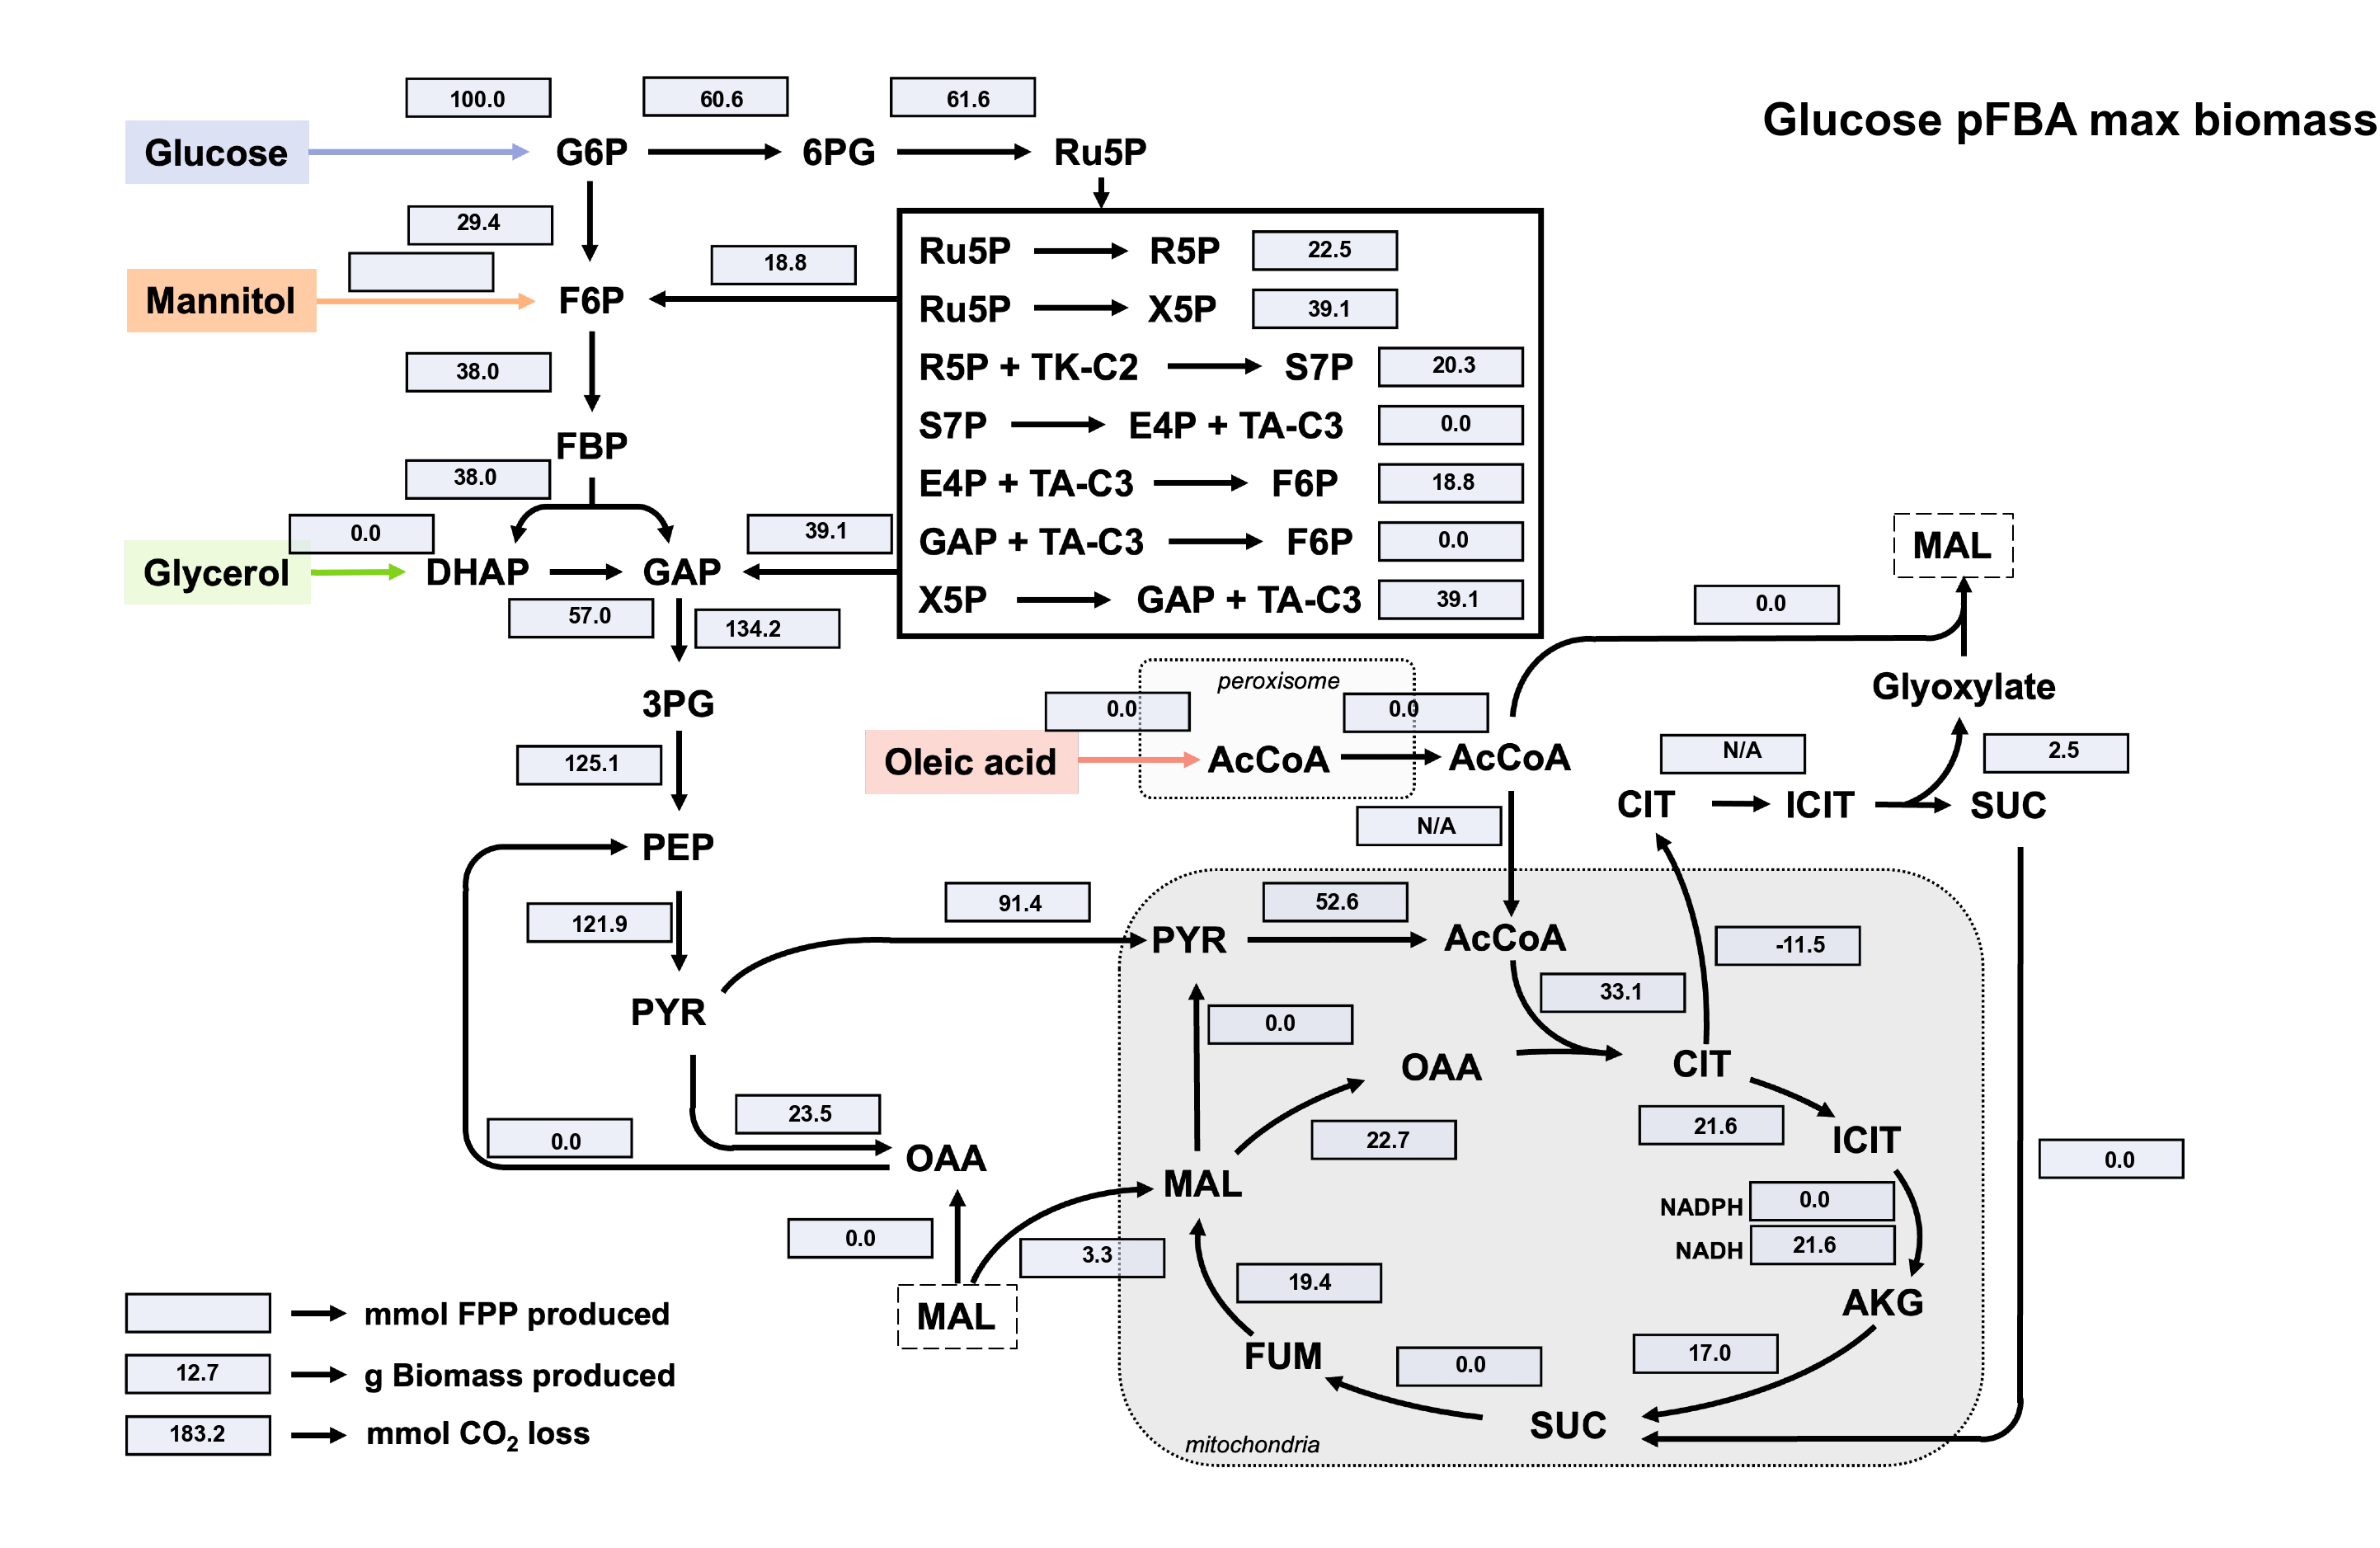

In [16]:
_ = generate_flux_map(
    flux_df=full_central_rxn_df, 
    flux_column='glucose_max_biomass_flux', 
    title_string='Glucose pFBA max biomass',
    file_name='../figures/test_flux_map.png',
    use_mannitol_map=True
)

### Run biomass-maximizing FBA for mannitol

In [28]:
# minimal medium with glycerol as sole carbon source
model.medium = {
  'EX_glc(e)': 0, 
  'EX_mannitol_e': 100.0, # 100 mmol of mannitol
  'EX_h2o(e)': 10000.0,
  'EX_h(e)': 10000.0,
  'EX_nh4(e)': 10000.0,
  'EX_o2(e)': 10000.0,
  'EX_pi(e)': 10000.0,
  'EX_so4(e)': 10000.0,
}
  
with model:
    # update the model to use the specified medium
    medium = model.medium

    # print the medium
    print('Media composition:')
    [print(model.medium[m], m) for m in model.medium]

    # set the objective to be the biomass reaction (this is the default behavior, but we'll be explicit)
    model.objective = model.reactions.get_by_id('EX_biom')

    # find the optimal solution
    solution = cobra.flux_analysis.pfba(model)

    print('\nBiomass flux', solution.fluxes['EX_biom'])
    
    # create a list to hold the max fpp fluxes
    flux_values = []

    # loop over the reactions in the fba_results_df dataframe, and add a column for FPP maximmizing glucose fluxes
    for _, row in fba_results_df.iterrows():
        reaction_id = row['reaction_id']
        flux = solution.fluxes[reaction_id]
        flux_values.append(flux)

# add the max fpp fluxes to the dataframe
fba_results_df['mannitol_max_biomass_flux'] = flux_values

fba_results_df.head()

EX_mannitol_e does not seem to be an an exchange reaction. Applying bounds anyway.


Media composition:
10000.0 EX_h2o(e)
10000.0 EX_h(e)
10000.0 EX_nh4(e)
10000.0 EX_o2(e)
10000.0 EX_pi(e)
10000.0 EX_so4(e)

Biomass flux 13.812288544473114


,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-585.152828,-632.205086
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],353.358197,382.804713
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],347.604940,376.572019
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,339.174176,367.438691
421,EX_h2o(e),H2O exchange,h2o[e] <=>,326.765643,403.996113


### Run FPP-maximizing FBA for glucose

In [29]:
# minimal medium with glucose as sole carbon source
model.medium = {
    'EX_glc(e)': 100.0, # 100 mmol of glucose
    'EX_mannitol_e': 0,
    'EX_h2o(e)': 10000.0,
    'EX_h(e)': 10000.0,
    'EX_nh4(e)': 10000.0,
    'EX_o2(e)': 10000.0,
    'EX_pi(e)': 10000.0,
    'EX_so4(e)': 10000.0,
}

solution = 0
  
with model:
    # update the model to use the specified medium
    medium = model.medium

    # print the medium
    print('Media composition:')
    [print(model.medium[m], m) for m in model.medium]

    # set the objective to be the farnesyl diphosphate exchange reaction
    model.objective = model.reactions.get_by_id('EX_frdp[c]')

    # find and display the optimal solution
    solution = cobra.flux_analysis.pfba(model)

    print('\nFPP flux', solution.fluxes['EX_frdp[c]'])

    # create a list to hold the max fpp fluxes
    max_fpp_fluxes = []

    # loop over the reactions in the fba_results_df dataframe, and add a column for FPP maximmizing glucose fluxes
    for _, row in fba_results_df.iterrows():
        reaction_id = row['reaction_id']
        flux = solution.fluxes[reaction_id]
        max_fpp_fluxes.append(flux)

# add the max fpp fluxes to the dataframe
fba_results_df['glucose_max_fpp_flux'] = max_fpp_fluxes

fba_results_df.head()

EX_mannitol_e does not seem to be an an exchange reaction. Applying bounds anyway.


Media composition:
100.0 EX_glc(e)
10000.0 EX_h2o(e)
10000.0 EX_h(e)
10000.0 EX_nh4(e)
10000.0 EX_o2(e)
10000.0 EX_pi(e)
10000.0 EX_so4(e)

FPP flux 22.35123367198844


,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,glucose_max_fpp_flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-585.152828,-632.205086,-541.848089
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],353.358197,382.804713,281.761006
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],347.604940,376.572019,281.761006
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,339.174176,367.438691,281.761006
421,EX_h2o(e),H2O exchange,h2o[e] <=>,326.765643,403.996113,354.136430


### Run FPP-maximizing FBA for mannitol

In [30]:
# minimal medium with glycerol as sole carbon source
model.medium = {
  'EX_glc(e)': 0, 
  'EX_mannitol_e': 100.0, # 100 mmol of mannitol
  'EX_h2o(e)': 10000.0,
  'EX_h(e)': 10000.0,
  'EX_nh4(e)': 10000.0,
  'EX_o2(e)': 10000.0,
  'EX_pi(e)': 10000.0,
  'EX_so4(e)': 10000.0,
}

solution = 0
  
with model:
    # update the model to use the specified medium
    medium = model.medium

    # print the medium
    print('Media composition:')
    [print(model.medium[m], m) for m in model.medium]

    # set the objective to be the farnesyl diphosphate exchange reaction
    model.objective = model.reactions.get_by_id('EX_frdp[c]')

    # find and display the optimal solution
    solution = cobra.flux_analysis.pfba(model)

    print('\nFPP flux', solution.fluxes['EX_frdp[c]'])

    # create a list to hold the max fpp fluxes
    max_fpp_fluxes = []

    # loop over the reactions in the fba_results_df dataframe, and add a column for FPP maximmizing mannitol fluxes
    for _, row in fba_results_df.iterrows():
        reaction_id = row['reaction_id']
        flux = solution.fluxes[reaction_id]
        max_fpp_fluxes.append(flux)

# add the max fpp fluxes to the dataframe
fba_results_df['mannitol_max_fpp_flux'] = max_fpp_fluxes

fba_results_df.head()

EX_mannitol_e does not seem to be an an exchange reaction. Applying bounds anyway.


Media composition:
10000.0 EX_h2o(e)
10000.0 EX_h(e)
10000.0 EX_nh4(e)
10000.0 EX_o2(e)
10000.0 EX_pi(e)
10000.0 EX_so4(e)

FPP flux 23.58490566037736


,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,glucose_max_fpp_flux,mannitol_max_fpp_flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-585.152828,-632.205086,-541.848089,-623.270440
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],353.358197,382.804713,281.761006,326.100629
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],347.604940,376.572019,281.761006,326.100629
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,339.174176,367.438691,281.761006,326.100629
421,EX_h2o(e),H2O exchange,h2o[e] <=>,326.765643,403.996113,354.136430,440.566038


### Analyze the fluxes out of the cell

In [31]:
# analyze the fate of carbon from mannitol
out_flux_df = fba_results_df[fba_results_df['reaction_id'].str.contains('EX_') == True]

# remove rows where glucose_max_biomass_flux	glucose_max_fpp_flux	mannitol_max_biomass_flux	and mannitol_max_fpp_flux are zero
out_flux_df = out_flux_df[(out_flux_df[['glucose_max_biomass_flux', 'glucose_max_fpp_flux', 'mannitol_max_biomass_flux', 'mannitol_max_fpp_flux']] != 0).all(axis=1)]

out_flux_df

,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,glucose_max_fpp_flux,mannitol_max_fpp_flux
421,EX_h2o(e),H2O exchange,h2o[e] <=>,326.765643,403.996113,354.136430,440.566038
391,EX_co2(e),CO2 exchange,co2[e] -->,183.219400,148.487684,264.731495,246.226415
444,EX_o2(e),O2 exchange,o2[e] <=>,-157.427758,-170.546738,-130.624093,-154.716981
442,EX_nh4(e),Ammonia exchange,nh4[e] <=>,-75.899688,-82.224662,-0.000000,-0.000000
451,EX_pi(e),Phosphate exchange,pi[e] <=>,-2.492679,-2.700402,-44.702467,-47.169811
422,EX_h(e),H exchange,h[e] <=>,-2.492679,-2.700402,-44.702467,-47.169811


### Define a function to get all the reactions with a certain metabolite

In [32]:
def get_reactions_with_metabolite(fba_results_df, metabolite_id):
    rows_to_add = []

    for _, row in fba_results_df.iterrows():
        reaction_id = row['reaction_id']
        reaction = model.reactions.get_by_id(reaction_id)
        metabolites = reaction.metabolites
        if any(met.id == metabolite_id for met in metabolites):
            rows_to_add.append(row)

    if rows_to_add:
        metabolite_df = pd.concat(rows_to_add, axis=1).T

        columns_to_check = ['glucose_max_biomass_flux', 'glucose_max_fpp_flux', 'mannitol_max_biomass_flux', 'mannitol_max_fpp_flux']
        metabolite_df = metabolite_df[(metabolite_df[columns_to_check].abs() > 0.001).any(axis=1)]

        
        return metabolite_df
    else:
        return pd.DataFrame()


### Analyze the source of extracellular CO2

In [33]:
get_reactions_with_metabolite(fba_results_df, 'co2[e]')

,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,glucose_max_fpp_flux,mannitol_max_fpp_flux
391,EX_co2(e),CO2 exchange,co2[e] -->,183.219400,148.487684,264.731495,246.226415
957,CO2t,CO2 transporter via diffusion,co2[e] <=> co2[c],-183.219400,-148.487684,-264.731495,-246.226415


### Analyze sources of intracellular CO2

In [34]:
get_reactions_with_metabolite(fba_results_df, 'co2[c]')

,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,glucose_max_fpp_flux,mannitol_max_fpp_flux
957,CO2t,CO2 transporter via diffusion,co2[e] <=> co2[c],-183.219400,-148.487684,-264.731495,-246.226415
999,CO2tm,CO2 transport diffusion mitochondrial,co2[c] <=> co2[m],-115.358583,-124.971798,-197.677794,-175.471698
646,GND,phosphogluconate dehydrogenase,6pgc[c] + nadp[c] --> co2[c] + nadph[c] + ru5p...,61.638763,16.775327,0.000000,0.000000
703,HCO3E,HCO3 equilibration reaction,co2[c] + h2o[c] <=> h[c] + hco3[c],61.609044,66.743131,132.559265,125.157233
1264,OMCDC,2 Oxo 4 methyl 3 carboxypentanoate decarboxyla...,3c4mop[c] + h[c] --> 4mop[c] + co2[c],16.635821,18.022139,66.279632,62.578616
1339,LEUDH,2-Oxoisovalerate dehydrogenase,4mop[c] + coa[c] + nad[c] --> co2[c] + ivcoa[c...,14.198068,15.381241,66.279632,62.578616
743,ICDHy,isocitrate dehydrogenase NADP,icit[c] + nadp[c] --> akg[c] + co2[c] + nadph[c],9.069601,9.825401,0.000000,0.000000
827,DPMVD,diphosphomevalonate decarboxylase,5dpmev[c] + atp[c] --> adp[c] + co2[c] + ipdp[...,3.131799,3.392782,67.053701,70.754717
234,FAS80COA_L,fatty acyl CoA synthase n C80CoA lumped reaction,accoa[c] + 9.0 h[c] + 3.0 malcoa[c] + 6.0 nadp...,3.006176,3.256690,0.000000,0.000000
209,FAS100COA,fatty acyl CoA synthase n C100CoA,3.0 h[c] + malcoa[c] + 2.0 nadph[c] + occoa[c]...,3.006176,3.256690,0.000000,0.000000


In [35]:
get_reactions_with_metabolite(fba_results_df, 'co2[m]')

,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,glucose_max_fpp_flux,mannitol_max_fpp_flux
999,CO2tm,CO2 transport diffusion mitochondrial,co2[c] <=> co2[m],-115.358583,-124.971798,-197.677794,-175.471698
363,PDHm,pyruvate dehydrogenase,coa[m] + nad[m] + pyr[m] --> accoa[m] + co2[m]...,52.620859,57.005931,66.279632,62.578616
171,ICDHym,Isocitrate dehydrogenase NADP,icit[m] + nadp[m] --> akg[m] + co2[m] + nadph[m],21.604201,23.404552,0.000000,0.000000
1135,ACLSm,acetolactate synthase mitochondrial,h[m] + 2.0 pyr[m] --> alac_S[m] + co2[m],18.800708,20.367434,66.279632,62.578616
107,AKGDam,oxoglutarate dehydrogenase lipoamide,akg[m] + h[m] + lpam[m] <=> co2[m] + sdhlam[m],16.956833,18.369902,0.000000,0.000000
912,OXAGm,non enzymatic reaction,h[m] + oxag[m] <=> 2oxoadp[m] + co2[m],3.445876,3.733032,0.000000,0.000000
1123,ACHBSm,2 aceto 2 hydroxybutanoate synthase mitochondrial,2obut[m] + h[m] + pyr[m] --> 2ahbut[m] + co2[m],1.134816,1.229384,0.000000,0.000000
750,PSERDm_SC,phosphatidylserine decarboxylase yeast specifi...,h[m] + 0.01 ps_SC[m] --> co2[m] + 0.01 pe_SC[m],0.795290,0.861564,0.000000,0.000000
815,ME2m,malic enzyme NADP mitochondrial,mal_L[m] + nadp[m] --> co2[m] + nadph[m] + pyr[m],0.000000,0.000000,63.957426,38.050314
662,GLYCLm,glycine cleavage system mitochondrial,gly[m] + nad[m] + thf[m] --> co2[m] + mlthf[m]...,0.000000,0.000000,1.161103,12.264151


In [36]:
# isolate isocitrate dehydrogenase
fba_results_df[fba_results_df['reaction_id'].str.contains('ICDHy') == True]

,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,glucose_max_fpp_flux,mannitol_max_fpp_flux
171,ICDHym,Isocitrate dehydrogenase NADP,icit[m] + nadp[m] --> akg[m] + co2[m] + nadph[m],21.604201,23.404552,0.000000,0.000000
743,ICDHy,isocitrate dehydrogenase NADP,icit[c] + nadp[c] --> akg[c] + co2[c] + nadph[c],9.069601,9.825401,0.000000,0.000000
745,ICDHyp,Isocitrate dehydrogenase NADP,icit[x] + nadp[x] --> akg[x] + co2[x] + nadph[x],0.000000,0.000000,0.000000,0.000000


In [37]:
model.reactions.get_by_id('ICDHy').metabolites

{<Metabolite akg[c] at 0x17f511ab0>: 1.0,
 <Metabolite co2[c] at 0x17d657400>: 1.0,
 <Metabolite icit[c] at 0x17f511780>: -1.0,
 <Metabolite nadp[c] at 0x17d655000>: -1.0,
 <Metabolite nadph[c] at 0x17d656c20>: 1.0}

In [38]:
any(met.id == 'co2[c]' for met in model.reactions.get_by_id('ICDHy').metabolites)

True

### Identify reactions with differential flux values

In [39]:
# split the dataframe into two dataframes, one for biomass and one for fpp
biomass_df = fba_results_df[['reaction_id', 'reaction_name', 'full_reaction', 'glucose_max_biomass_flux', 'mannitol_max_biomass_flux']]
fpp_df = fba_results_df[['reaction_id', 'reaction_name', 'full_reaction', 'glucose_max_fpp_flux', 'mannitol_max_fpp_flux']]

display(biomass_df.head())
display(fpp_df.head())


,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-585.152828,-632.205086
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],353.358197,382.804713
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],347.604940,376.572019
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,339.174176,367.438691
421,EX_h2o(e),H2O exchange,h2o[e] <=>,326.765643,403.996113


,reaction_id,reaction_name,full_reaction,glucose_max_fpp_flux,mannitol_max_fpp_flux
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-541.848089,-623.270440
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],281.761006,326.100629
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],281.761006,326.100629
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,281.761006,326.100629
421,EX_h2o(e),H2O exchange,h2o[e] <=>,354.136430,440.566038


### Add columns comparing the glucose and mannitol solutions

In [40]:
# a function that adds a columns for difference and percent difference
def add_difference_columns(_df, column_1, column_2):
    df = _df.copy()

    df['difference'] = df[column_1] - df[column_2]
    df['percent_difference'] = df['difference'] / df[column_1] * 100

    # add a column for the absolute value of the percent difference
    df['absolute_difference'] = abs(df['difference'])


    df = df.sort_values(by=['absolute_difference'], ascending=False)

    # drop the absolute percent difference column
    df = df.drop(columns=['absolute_difference'])

    return df

# add the difference columns to the dataframes
biomass_df = add_difference_columns(biomass_df, 'glucose_max_biomass_flux', 'mannitol_max_biomass_flux')
fpp_df = add_difference_columns(fpp_df, 'glucose_max_fpp_flux', 'mannitol_max_fpp_flux')

display(biomass_df.head())
display(fpp_df.head())

,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,difference,percent_difference
360,HEX7,hexokinase D fructoseATP,atp[c] + fru[c] --> adp[c] + f6p[c] + h[c],0.000000,100.000000,-100.000000,-inf
1353,MNLDH2,mannitol dehydrogenase,mannitol[c] + nadp[c] --> fru[c] + h[c] + nadp...,0.000000,100.000000,-100.000000,-inf
413,EX_glc(e),D Glucose exchange,glc_D[e] <=>,-100.000000,0.000000,-100.000000,100.000000
1351,EX_mannitol_e,mannitol exchange,mannitol[e] -->,0.000000,-100.000000,100.000000,inf
1352,mannitol_transport,mannitol transport,mannitol[e] --> mannitol[c],0.000000,100.000000,-100.000000,-inf


,reaction_id,reaction_name,full_reaction,glucose_max_fpp_flux,mannitol_max_fpp_flux,difference,percent_difference
360,HEX7,hexokinase D fructoseATP,atp[c] + fru[c] --> adp[c] + f6p[c] + h[c],0.000000,100.000000,-100.000000,-inf
1353,MNLDH2,mannitol dehydrogenase,mannitol[c] + nadp[c] --> fru[c] + h[c] + nadp...,0.000000,100.000000,-100.000000,-inf
413,EX_glc(e),D Glucose exchange,glc_D[e] <=>,-100.000000,0.000000,-100.000000,100.000000
1351,EX_mannitol_e,mannitol exchange,mannitol[e] -->,0.000000,-100.000000,100.000000,inf
1352,mannitol_transport,mannitol transport,mannitol[e] --> mannitol[c],0.000000,100.000000,-100.000000,-inf


### 

### Glucose vs. mannitol (differential fluxes for max biomass)

In [41]:
# filter the biomass dataframe to only include reactions with greater than 5 flux units for at least one of the carbon sources
biomass_df = biomass_df[(abs(biomass_df['glucose_max_biomass_flux']) > 5) | (abs(biomass_df['mannitol_max_biomass_flux']) > 5)]

biomass_df.head(30)

,reaction_id,reaction_name,full_reaction,glucose_max_biomass_flux,mannitol_max_biomass_flux,difference,percent_difference
360,HEX7,hexokinase D fructoseATP,atp[c] + fru[c] --> adp[c] + f6p[c] + h[c],0.000000,100.000000,-100.000000,-inf
1353,MNLDH2,mannitol dehydrogenase,mannitol[c] + nadp[c] --> fru[c] + h[c] + nadp...,0.000000,100.000000,-100.000000,-inf
413,EX_glc(e),D Glucose exchange,glc_D[e] <=>,-100.000000,0.000000,-100.000000,100.000000
1351,EX_mannitol_e,mannitol exchange,mannitol[e] -->,0.000000,-100.000000,100.000000,inf
1352,mannitol_transport,mannitol transport,mannitol[e] --> mannitol[c],0.000000,100.000000,-100.000000,-inf
958,GLCt1,glucose transport uniport,glc_D[e] --> glc_D[c],100.000000,0.000000,100.000000,100.000000
711,HEX1,hexokinase D glucoseATP,atp[c] + glc_D[c] --> adp[c] + g6p[c] + h[c],100.000000,0.000000,100.000000,100.000000
421,EX_h2o(e),H2O exchange,h2o[e] <=>,326.765643,403.996113,-77.230470,-23.634820
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-326.765643,-403.996113,77.230470,-23.634820
547,PGI,glucose 6 phosphate isomerase,g6p[c] <=> f6p[c],29.434150,-26.446338,55.880488,189.849165


### Glucose vs. mannitol (differential fluxes for max FPP)

In [42]:
# filter the fpp dataframe to only include reactions with greater than 5 flux units for at least one of the carbon sources
fpp_df = fpp_df[(abs(fpp_df['glucose_max_fpp_flux']) > 5) | (abs(fpp_df['mannitol_max_fpp_flux']) > 5)]

fpp_df.head(30)

,reaction_id,reaction_name,full_reaction,glucose_max_fpp_flux,mannitol_max_fpp_flux,difference,percent_difference
360,HEX7,hexokinase D fructoseATP,atp[c] + fru[c] --> adp[c] + f6p[c] + h[c],0.000000,100.000000,-100.000000,-inf
1353,MNLDH2,mannitol dehydrogenase,mannitol[c] + nadp[c] --> fru[c] + h[c] + nadp...,0.000000,100.000000,-100.000000,-inf
413,EX_glc(e),D Glucose exchange,glc_D[e] <=>,-100.000000,0.000000,-100.000000,100.000000
1351,EX_mannitol_e,mannitol exchange,mannitol[e] -->,0.000000,-100.000000,100.000000,inf
1352,mannitol_transport,mannitol transport,mannitol[e] --> mannitol[c],0.000000,100.000000,-100.000000,-inf
547,PGI,glucose 6 phosphate isomerase,g6p[c] <=> f6p[c],100.000000,0.000000,100.000000,100.000000
958,GLCt1,glucose transport uniport,glc_D[e] --> glc_D[c],100.000000,0.000000,100.000000,100.000000
711,HEX1,hexokinase D glucoseATP,atp[c] + glc_D[c] --> adp[c] + g6p[c] + h[c],100.000000,-0.000000,100.000000,100.000000
421,EX_h2o(e),H2O exchange,h2o[e] <=>,354.136430,440.566038,-86.429608,-24.405738
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-354.136430,-440.566038,86.429608,-24.405738


### Print out details of mevalonate pathway
The purpose of this was to determine the reason why carotenoids require NADPH.
<br><br>
The answer was the reaction of HMG-CoA + 2 NADPH -> Mevalonate (HMG-CoA reductase)

In [43]:
def print_metablite_details(metabolite_id):
    metabolite = model.metabolites.get_by_id(metabolite_id)
    print(f'{metabolite.name} ({metabolite.id}) reactions:')
    for reaction in metabolite.reactions:
        print(reaction, reaction.name)

    print()

print_metablite_details('accoa[c]')
print_metablite_details('hmgcoa[c]')
print_metablite_details('mev_R[c]')
print_metablite_details('5pmev[c]')
print_metablite_details('5dpmev[c]')
print_metablite_details('ipdp[c]')
print_metablite_details('dmpp[c]')
print_metablite_details('grdp[c]')
print_metablite_details('frdp[c]')

Acetyl_CoA (accoa[c]) reactions:
ACACT1: 2.0 accoa[c] <=> aacoa[c] + coa[c] acetyl CoA C acetyltransferase
DIAT: accoa[c] + sprm[c] --> N1sprm[c] + coa[c] + h[c] diamine transaminase
ACGAM6PS: accoa[c] + gam6p[c] <=> acgam6p[c] + coa[c] + h[c] N acetylglucosamine 6 phosphate synthase
HMGCOAS: coa[c] + h[c] + hmgcoa[c] <=> aacoa[c] + accoa[c] + h2o[c] Hydroxymethylglutaryl CoA synthase
ACS: ac[c] + atp[c] + coa[c] --> accoa[c] + amp[c] + ppi[c] acetyl CoA synthetase
ACOATA: ACP[c] + accoa[c] <=> acACP[c] + coa[c] Acetyl CoA ACP transacylase
ACACCT: acac[c] + accoa[c] --> aacoa[c] + ac[c] Acetyl-CoA:acetoacetyl-CoA transferase
SPMDAT1: accoa[c] + spmd[c] --> N1aspmd[c] + coa[c] + h[c] Spermidine acetyltransferase
IPPS: 3mob[c] + accoa[c] + h2o[c] --> 3c3hmp[c] + coa[c] + h[c] 2 isopropylmalate synthase
SERATi: accoa[c] + ser_L[c] --> acser[c] + coa[c] serine O acetyltransferase irreversible
FAS80_L: accoa[c] + 8.0 h[c] + 3.0 malcoa[c] + 6.0 nadph[c] --> 3.0 co2[c] + 4.0 coa[c] + 2.0 h2o[